# Named Entity Recognition (NER) for PDF Documents Analysis

This Jupyter notebook implements a comprehensive Named Entity Recognition (NER) system specifically designed for analyzing PDF documents. The system focuses on extracting and analyzing person names (PER entities) from documents, with particular optimization for German language texts.

## Key Features:

1. **Multi-Language Support**:
   - Handles English, German, French, and Spanish texts
   - Automatically detects document language
   - Uses specialized language models for accurate entity recognition

2. **PDF Processing**:
   - Extracts text from PDF documents
   - Handles both searchable PDFs and scanned documents
   - Processes documents in chunks to manage large files

3. **Entity Processing**:
   - Focuses on person name extraction (PER entities)
   - Implements intelligent name normalization
   - Filters out false positives
   - Provides context for extracted entities

4. **Visualization Features**:
   - Creates bar plots of top entities
   - Generates word clouds
   - Provides year-wise analysis for temporal insights
   - Visualizes entity distribution across documents

5. **Output Generation**:
   - Produces detailed Excel reports
   - Creates summary sheets with entity counts
   - Generates year-specific analysis
   - Includes context for each extracted entity

This notebook is particularly useful for researchers and analysts working with historical documents or large collections of PDF files who need to extract and analyze named entities, especially person names, with a focus on accuracy and context preservation.

The system includes robust error handling, progress tracking, and detailed output formatting, making it suitable for both small-scale and large-scale document analysis projects.

In [3]:
# Cell 1: Install Required Libraries
"""
# Named Entity Recognition (NER) for PDF Documents
"""
!pip install spacy langdetect pdfplumber tqdm pytesseract pdf2image wordcloud seaborn matplotlib xlsxwriter
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_lg
!python -m spacy download fr_core_news_sm
!python -m spacy download es_core_news_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 67.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.8/31.8 MB 165.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 206.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 539.2/539.2 kB 250.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 346.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 209.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 216.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 186.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 178.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 135.6 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993284 sha256=de1467aea9ea405b9f6fc1ff65be92306a43bc16af19ab37a7d646daaa9c55c6
  Stored i

In [54]:
# Cell 2: Import Libraries
import os
import spacy
from langdetect import detect
import pdfplumber
from collections import Counter, defaultdict
import pandas as pd
from tqdm import tqdm
import pytesseract
from pdf2image import convert_from_path
import tempfile
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np
%matplotlib inline
plt.style.use('seaborn-v0_8')

print("All libraries successfully imported!")


All libraries successfully imported!


In [77]:
# Cell 3: Configure Entity Types and Functions
SELECTED_ENTITY_TYPES = [
    'PER',      # People's names
#    'ORG',      # Organizations
#    'GPE',      # Countries, cities, states
#    'LOC',      # Non-GPE locations
#    'DATE',     # Dates
]

def is_valid_person_name(text):
    """
    Enhanced check if the extracted text is likely to be a person name
    """
    # Common German words that are often falsely recognized as names
    false_positives = {
        'Amen', 'Gottes', 'Evangelisationen', 'Talare', 'Wandsprüche',
        'Korrespondenzkursen', 'Kindruck', 'Offbg', 'Ach',
        # Add more false positives as needed
    }
    
    # Normalize text for checking
    text_lower = text.lower()
    
    # Basic validations
    if len(text) < 2:
        return False
    
    if text in false_positives:
        return False
    
    if any(char.isdigit() for char in text):
        return False
    
    return True

def normalize_german_name(name):
    """
    Normalize German names with improved case handling
    """
    # Dictionary of known name variations (all in lowercase for comparison)
    name_variations = {
        'luthers': 'Luther',
        'luther': 'Luther',
        # Add more variations as needed
    }
    
    # Clean and standardize the name
    cleaned_name = name.strip().lower()
    
    # Check if this is a known variation
    if cleaned_name in name_variations:
        return name_variations[cleaned_name]
    
    return name

class GermanNameProcessor:
    def __init__(self):
        self.known_names = set()
        self.name_variations = {
            'luthers': 'Luther',
            'luther': 'Luther',
            # Add more variations as needed
        }
    
    def process_name(self, name, context=""):
        """
        Process a German name with improved normalization
        """
        if not is_valid_person_name(name):
            return None
            
        if name.lower() in self.name_variations:
            return self.name_variations[name.lower()]
            
        if name in self.known_names:
            return name
            
        # If passed all validations, add to known names
        self.known_names.add(name)
        return name

# Define Text Extraction Function
def extract_text_from_pdf(pdf_path):
    """
    Extracts text from a PDF file using pdfplumber
    Returns the extracted text as a string
    """
    text = ""
    try:
        with pdfplumber.open(pdf_path) as pdf:
            for page in pdf.pages:
                text += page.extract_text() or ""
        # print(f"\nSample of extracted text:\n{text[:500]}...")
        return text
    except Exception as e:
        print(f"Error processing {pdf_path}: {str(e)}")
        return ""

# Define Language Detection and Model Loading Function
def load_spacy_model(text):
    """
    Detects the language of the text and loads appropriate spaCy model
    Returns the loaded model and detected language
    """
    # Function code here (same as in original)
    try:
        lang = detect(text)
        
        # Map detected language to spaCy model
        lang_models = {
            'en': 'en_core_web_sm',
            'de': 'de_core_news_lg',  # Changed to larger German model
            'fr': 'fr_core_news_sm',
            'es': 'es_core_news_sm',
        }
        
        if lang in lang_models:
            model_name = lang_models[lang]
            try:
                nlp = spacy.load(model_name)
                # For German text, add some pipeline customizations
                if lang == 'de':
                    nlp.max_length = 2000000  # Increase max text length
            except OSError:
                print(f"Downloading language model for {lang}...")
                spacy.cli.download(model_name)
                nlp = spacy.load(model_name)
            return nlp, lang
        else:
            print(f"No available spaCy model for detected language: {lang}")
            return None, lang
    except Exception as e:
        print(f"Error in language detection: {str(e)}")
        return None, None
    
def process_entities(doc, detected_lang="de"):
    """
    Processes entities in the document with improved name normalization
    """
    name_processor = GermanNameProcessor()
    entity_counts = defaultdict(Counter)
    entities_list = []
    
    # Create a mapping to track normalized names
    normalized_entities = {}
    
    # Count only selected entity types
    selected_entities = [ent for ent in doc.ents if ent.label_ in SELECTED_ENTITY_TYPES]
    print(f"\nTotal {', '.join(SELECTED_ENTITY_TYPES)} entities found: {len(selected_entities)}")
    
    for ent in selected_entities:
        if ent.label_ == 'PER' and detected_lang == 'de':
            # Get context window
            start_idx = max(0, ent.start_char - 100)
            end_idx = min(len(doc.text), ent.end_char + 100)
            context = doc.text[start_idx:end_idx].replace('\n', ' ').strip()
            
            # Process German person names
            processed_name = name_processor.process_name(ent.text, context)
            if not processed_name:
                continue
            
            # Normalize the name
            entity_text = normalize_german_name(processed_name)
            
            # Store the original-normalized name mapping
            normalized_entities[ent.text] = entity_text
        else:
            entity_text = ent.text
        
        # Debug: Print only selected entity types
        # print(f"Found {ent.label_}: {entity_text} (original: {ent.text})")
        
        entity_detail = {
            'text': entity_text,
            'original_text': ent.text,
            'label': ent.label_,
            'start': ent.start_char,
            'end': ent.end_char,
            'context': context if 'context' in locals() else doc.text[max(0, ent.start_char - 100):min(len(doc.text), ent.end_char + 100)].replace('\n', ' ').strip()
        }
        entities_list.append(entity_detail)
        entity_counts[ent.label_][entity_text] += 1
    
    # Print normalization summary
    # print("\nName Normalization Summary:")
    # print("=" * 40)
    # for original, normalized in normalized_entities.items():
    #    if original != normalized:
    #        print(f"'{original}' -> '{normalized}'")
    
    return entity_counts, entities_list

def analyze_pdf(pdf_path):
    """
    Main function to analyze a PDF file
    """
    print(f"\nProcessing: {pdf_path}")
    
    # Extract text
    text = extract_text_from_pdf(pdf_path)
    if not text.strip():
        print("No text could be extracted from PDF")
        return None
    
    # Load model
    nlp, detected_lang = load_spacy_model(text)
    if nlp is None:
        return None
    
    print(f"Detected language: {detected_lang}")
    
    # Process text in chunks to handle large documents
    max_length = 100000
    texts = [text[i:i+max_length] for i in range(0, len(text), max_length)]
    
    all_entity_counts = defaultdict(Counter)
    all_entities_list = []
    
    for text_chunk in texts:
        doc = nlp(text_chunk)
        entity_counts, entities_list = process_entities(doc, detected_lang)
        
        # Merge results
        for label, counts in entity_counts.items():
            all_entity_counts[label].update(counts)
        all_entities_list.extend(entities_list)
    
    return {
        'language': detected_lang,
        'entity_counts': all_entity_counts,
        'entities_list': all_entities_list
    }




In [78]:
# Cell 4:
def visualize_top_entities(df_entities):
    """
    Visualize top 10 entities with normalization information
    """
    # Calculate top 10 entities
    top_entities = df_entities.groupby('Entity')['Count'].sum().sort_values(ascending=False).head(10)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    
    # Bar plot
    sns.barplot(x=top_entities.values, y=top_entities.index, ax=ax1, palette='viridis')
    ax1.set_title('Top 10 Most Frequent Entities (Normalized)', pad=20, size=14)
    ax1.set_xlabel('Frequency')
    ax1.set_ylabel('Entity')
    
    # Word Cloud
    word_freq = df_entities.groupby('Entity')['Count'].sum().to_dict()
    
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=50,
        prefer_horizontal=0.7
    ).generate_from_frequencies(word_freq)
    
    ax2.imshow(wordcloud, interpolation='bilinear')
    ax2.axis('off')
    ax2.set_title('Entity Word Cloud (Normalized)', pad=20, size=14)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary including original forms
    print("\nTop 10 Most Frequent Entities (with original forms):")
    print("=" * 60)
    for entity, count in top_entities.items():
        original_forms = df_entities[df_entities['Entity'] == entity]['Original_Entity'].unique()
        print(f"{entity}: {count} (Original forms: {', '.join(original_forms)})")


Processing PDFs:   0%|          | 0/3 [00:00<?, ?it/s]


Processing: ./data/1947-jahrbuch-des-martinlutherbundes.pdf
Detected language: de

Total PER entities found: 831

Total PER entities found: 622

Total PER entities found: 509

Total PER entities found: 519


Processing PDFs:  33%|███▎      | 1/3 [00:52<01:44, 52.45s/it]


Total PER entities found: 67

Processing: ./data/1948-jahrbuch-des-martinlutherbundes_searchable.pdf
Detected language: de

Total PER entities found: 285

Total PER entities found: 225

Total PER entities found: 202

Total PER entities found: 261


Processing PDFs:  67%|██████▋   | 2/3 [01:29<00:43, 43.49s/it]


Total PER entities found: 64

Processing: ./data/1946-jahrbuch-des-martinlutherbundes_searchable.pdf
Detected language: de

Total PER entities found: 706

Total PER entities found: 380

Total PER entities found: 335


Processing PDFs: 100%|██████████| 3/3 [02:07<00:00, 42.41s/it]


Total PER entities found: 23

Entity Analysis Results

File: 1947-jahrbuch-des-martinlutherbundes.pdf
Language: de

PER entities found: 2338
------------------------------
Luther: 47
ber: 40
ott: 33
sınd: 30
Eckhardt: 21
Sanz: 17
Jesus: 15
ıhm: 13
mıiıt: 10
Zeıt: 10

File: 1948-jahrbuch-des-martinlutherbundes_searchable.pdf
Language: de

PER entities found: 1006
------------------------------
Luther: 181
Christus: 24
Gott: 21
A.T.: 21
Christi: 19
Paulus: 19
Teufel: 18
Jesus Christus: 14
Martin Luther-Bund: 13
Jesus: 13

File: 1946-jahrbuch-des-martinlutherbundes_searchable.pdf
Language: de

PER entities found: 1405
------------------------------
Luther: 116
Christus: 43
Engel: 24
Teufel: 22
Gott: 21
Christi: 14
Jesu: 13
Martin Luther: 11
Sohn: 11
ıhm: 9

Generating visualizations by year...



/tmp/ipykernel_290/1483356321.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_entities, x='Count', y='Entity', ax=ax_bar, palette='viridis')
/tmp/ipykernel_290/1483356321.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_entities, x='Count', y='Entity', ax=ax_bar, palette='viridis')
/tmp/ipykernel_290/1483356321.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_entities, x='Count', y='Entity', ax=ax_bar, palette='viridis')



Top Entities by Year:

Year 1946:
------------------------------
Luther: 13456
Christus: 1849
Engel: 576
Teufel: 484
Gott: 441

Year 1947:
------------------------------
Luther: 2209
ber: 1600
ott: 1089
sınd: 900
Eckhardt: 441

Year 1948:
------------------------------
Luther: 32761
Christus: 576
A.T.: 441
Gott: 441
Christi: 361

Detailed results saved to: ./data/analysis_results/named_entities_analysis.xlsx


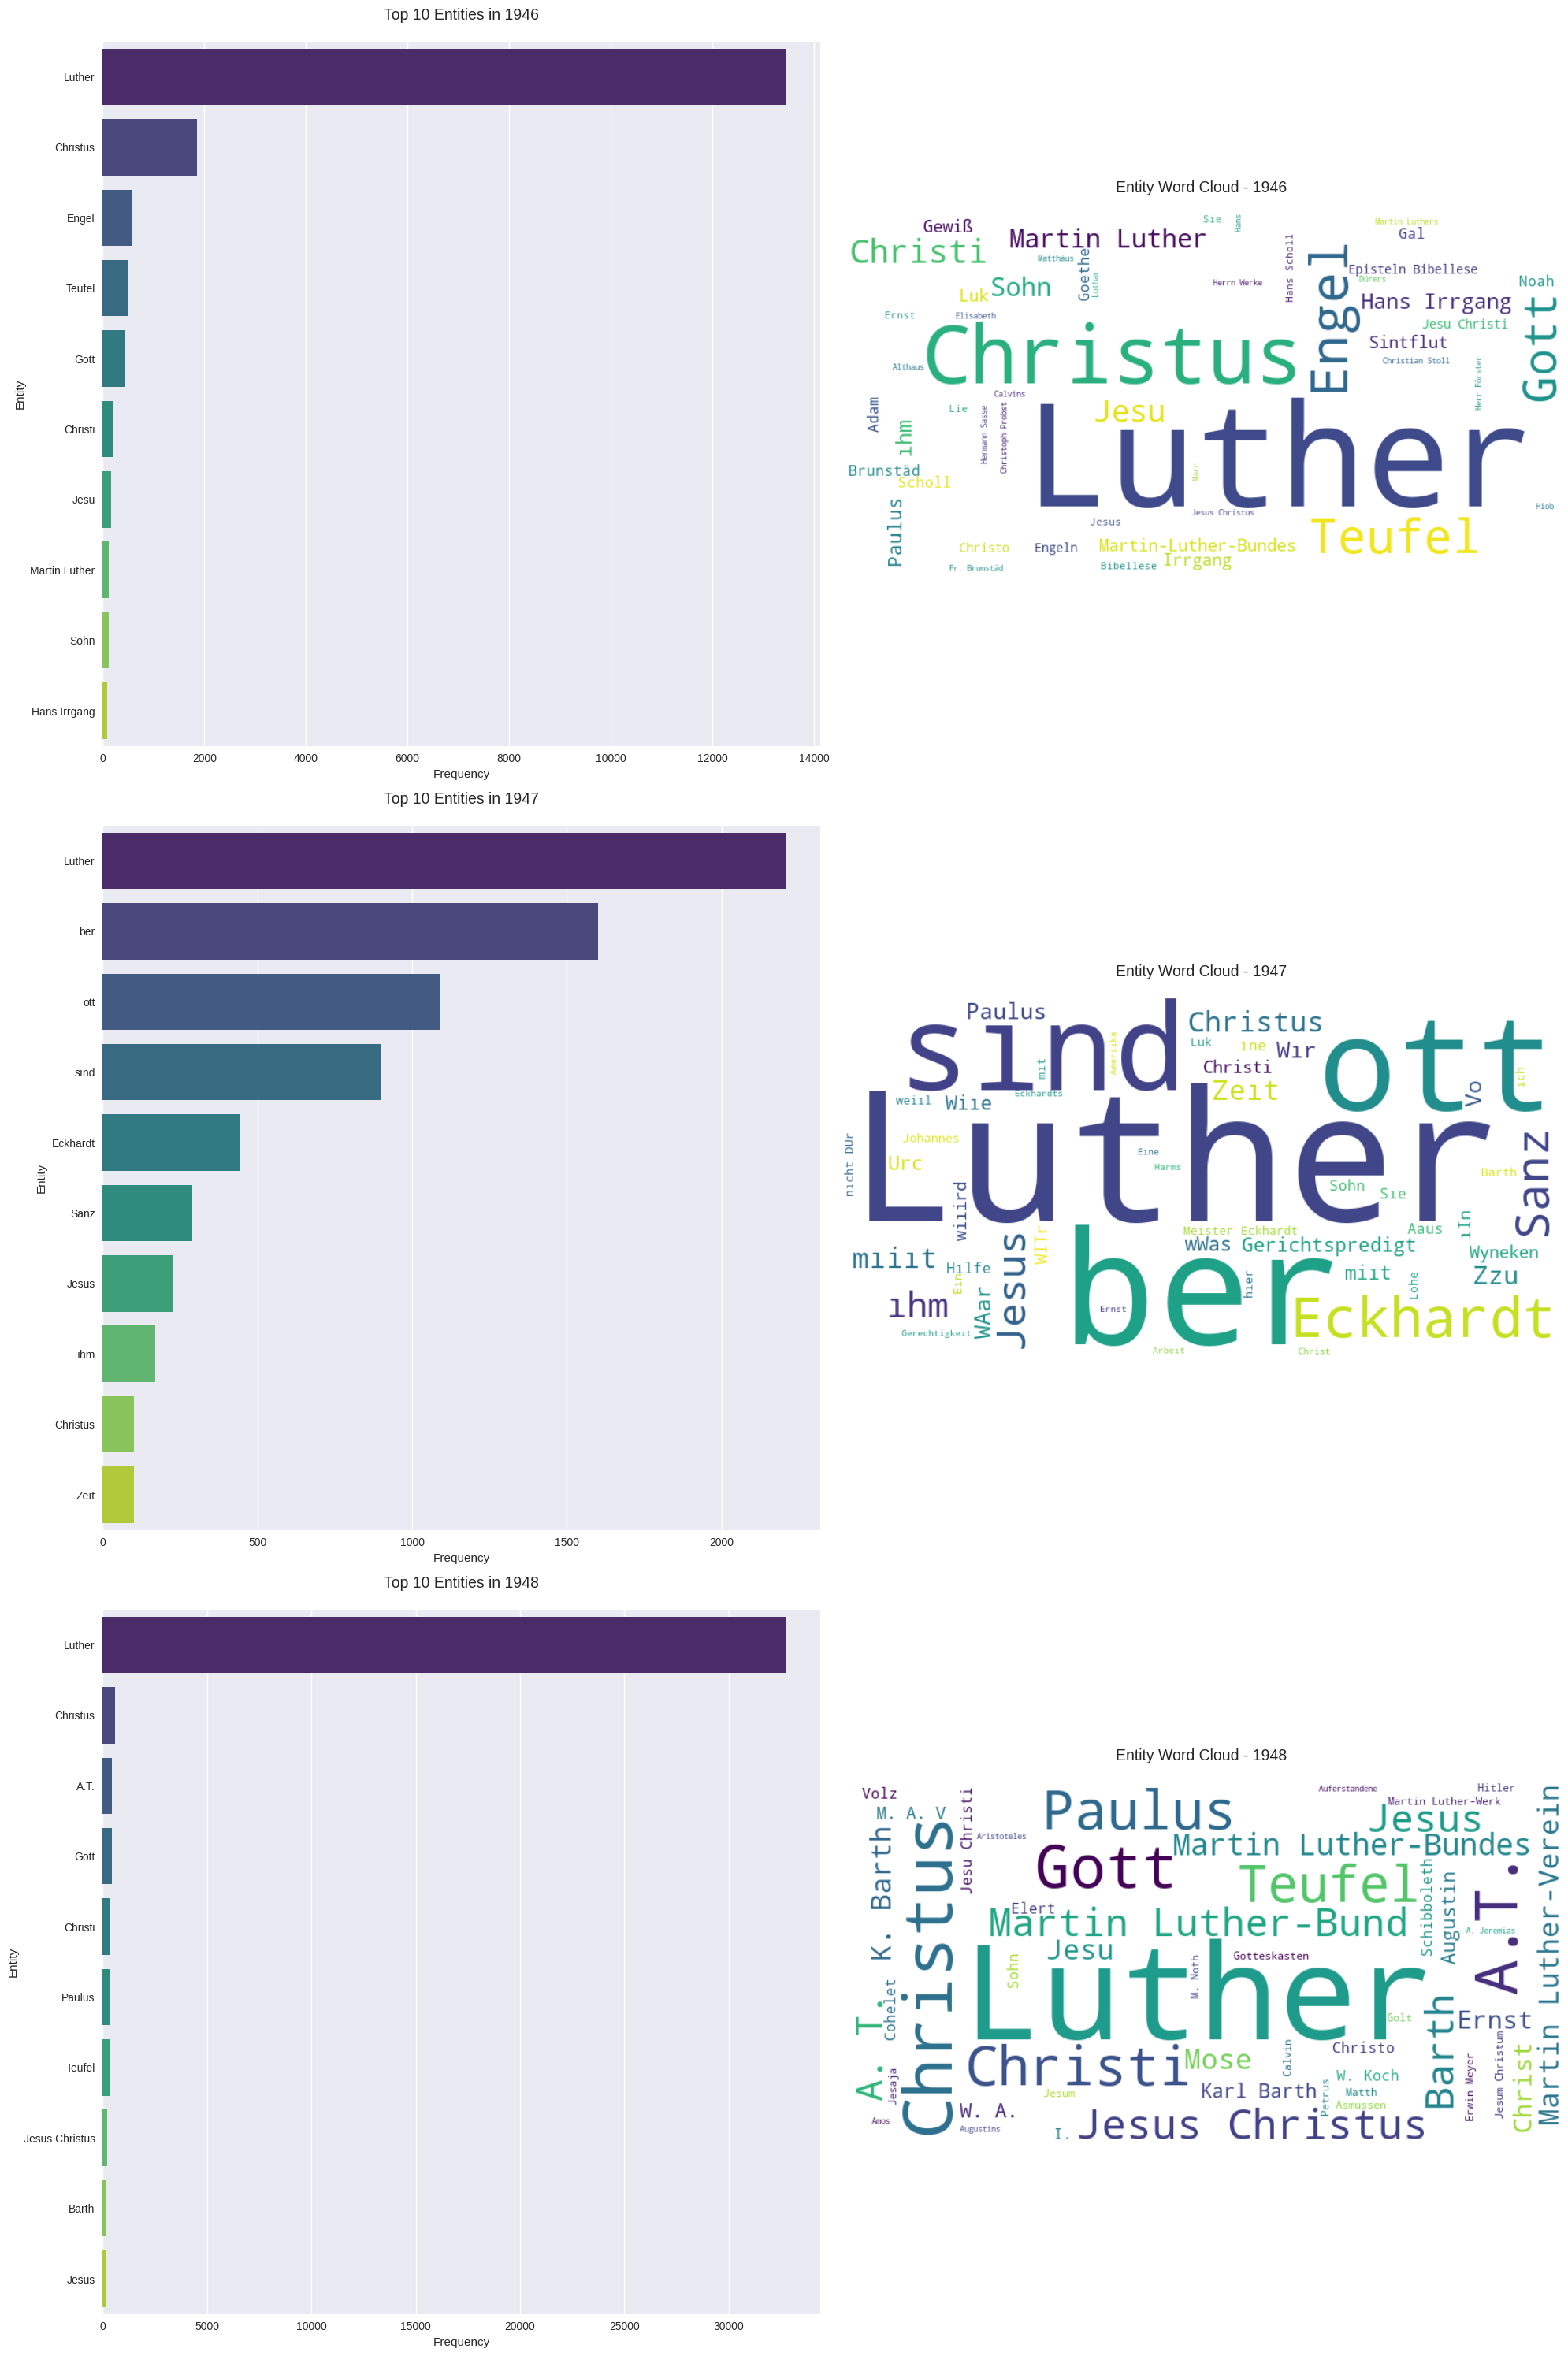

In [79]:
# Cell 5: Enhanced Visualization Functions for Year Analysis
def extract_year_from_filename(filename):
    """
    Extract year from filename format like "1947-xxx-xxx.pdf"
    """
    try:
        # Extract year from the start of the filename
        year = filename.split('-')[0]
        return int(year)
    except:
        return None

def visualize_entities_by_year(df_entities):
    """
    Visualize entities grouped by year with both bar plots and word clouds
    """
    # Extract year from PDF_File column
    df_entities['Year'] = df_entities['PDF_File'].apply(extract_year_from_filename)
    
    # Group by Year and Entity, sum the counts
    yearly_entities = df_entities.groupby(['Year', 'Entity'])['Count'].sum().reset_index()
    
    # Get unique years
    years = sorted(yearly_entities['Year'].unique())
    
    # Create a figure with subplots: one row for bar plots, one for word clouds
    fig = plt.figure(figsize=(20, 10 * len(years)))
    gs = fig.add_gridspec(len(years), 2)
    
    for idx, year in enumerate(years):
        # Filter data for this year
        year_data = yearly_entities[yearly_entities['Year'] == year]
        top_entities = year_data.nlargest(10, 'Count')
        
        # Create bar plot for this year
        ax_bar = fig.add_subplot(gs[idx, 0])
        sns.barplot(data=top_entities, x='Count', y='Entity', ax=ax_bar, palette='viridis')
        ax_bar.set_title(f'Top 10 Entities in {year}', pad=20, size=14)
        ax_bar.set_xlabel('Frequency')
        ax_bar.set_ylabel('Entity')
        
        # Create word cloud for this year
        ax_cloud = fig.add_subplot(gs[idx, 1])
        word_freq = year_data.set_index('Entity')['Count'].to_dict()
        
        if word_freq:  # Only create word cloud if there are entities
            wordcloud = WordCloud(
                width=800,
                height=400,
                background_color='white',
                max_words=50,
                prefer_horizontal=0.7
            ).generate_from_frequencies(word_freq)
            
            ax_cloud.imshow(wordcloud, interpolation='bilinear')
            ax_cloud.set_title(f'Entity Word Cloud - {year}', pad=20, size=14)
        ax_cloud.axis('off')
    
    plt.tight_layout()
    plt.show
    
    # Print summary table
    print("\nTop Entities by Year:")
    print("=" * 60)
    for year in years:
        year_data = yearly_entities[yearly_entities['Year'] == year]
        top_5 = year_data.nlargest(5, 'Count')
        print(f"\nYear {year}:")
        print("-" * 30)
        for _, row in top_5.iterrows():
            print(f"{row['Entity']}: {row['Count']}")

# Single Main Function
def main():
    # Set your PDF directory path
    pdf_directory = "./data"  # Replace with your path
    
    # Create output directory
    output_directory = os.path.join(pdf_directory, 'analysis_results')
    os.makedirs(output_directory, exist_ok=True)
    
    # Process all PDF files
    results = {}
    pdf_files = [f for f in os.listdir(pdf_directory) if f.endswith('.pdf')]

    for pdf_file in tqdm(pdf_files, desc="Processing PDFs"):
        pdf_path = os.path.join(pdf_directory, pdf_file)
        results[pdf_file] = analyze_pdf(pdf_path)

    # Display results
    print("\nEntity Analysis Results")
    print("="*50)
    
    all_entities = []
    
    for pdf_file, result in results.items():
        if result is None:
            continue
            
        print(f"\nFile: {pdf_file}")
        print(f"Language: {result['language']}")
        
        if not result['entity_counts']:
            print("No entities found in this document.")
            continue
        
        for entity_type, counts in result['entity_counts'].items():
            print(f"\n{entity_type} entities found: {sum(counts.values())}")
            print("-" * 30)
            
            sorted_entities = sorted(counts.items(), key=lambda x: x[1], reverse=True)
            
            for entity, count in sorted_entities[:10]:
                print(f"{entity}: {count}")
                
        for entity in result['entities_list']:
            all_entities.append({
                'PDF_File': pdf_file,
                'Entity': entity['text'],
                'Type': entity['label'],
                'Count': result['entity_counts'][entity['label']][entity['text']],
                'Context': entity['context'],
                'Language': result['language']
            })

    if all_entities:
        df_entities = pd.DataFrame(all_entities)
        
        # Display visualizations by year
        print("\nGenerating visualizations by year...")
        visualize_entities_by_year(df_entities)
        
        # Save to Excel
        output_directory = os.path.join(pdf_directory, 'analysis_results')
        os.makedirs(output_directory, exist_ok=True)
        excel_path = os.path.join(output_directory, 'named_entities_analysis.xlsx')
        
        with pd.ExcelWriter(excel_path, engine='xlsxwriter') as writer:
            # Summary sheet with year grouping
            df_summary = df_entities.groupby(['Year', 'Type', 'Entity'])['Count'].sum().reset_index()
            df_summary = df_summary.sort_values(['Year', 'Type', 'Count'], ascending=[True, True, False])
            df_summary.to_excel(writer, sheet_name='Summary', index=False)
            
            # Detailed sheet
            df_entities.to_excel(writer, sheet_name='Detailed', index=False)
            
            # Entity type sheets by year
            for entity_type in SELECTED_ENTITY_TYPES:
                df_type = df_entities[df_entities['Type'] == entity_type]
                if not df_type.empty:
                    df_type.to_excel(writer, sheet_name=f'{entity_type[:30]}', index=False)
            
            # Year-specific sheets
            for year in df_entities['Year'].unique():
                df_year = df_entities[df_entities['Year'] == year]
                if not df_year.empty:
                    df_year.to_excel(writer, sheet_name=f'Year_{year}', index=False)
        
        print(f"\nDetailed results saved to: {excel_path}")
    else:
        print("\nNo entities were found in any of the documents.")

if __name__ == "__main__":
    main()